<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: Calibrating the F test for spectral peaks</h1>
<h2>Does power have one or two DOF's per frequency?</h2>
<h3>Brian Mapes, spring 2020</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Methods of time series analysis
1. <a href="#spectrum">Specify white spectrum, make a very long series</a>
1. <a href="#chopchop">Chop into segments and compute their pow(freqs) spectra</a>
1. <a href="#peak5">Find the 5th highest peak</a>
1. <a href="#results">RESULTS: the answer is 2 DOFs</a>

--------

# The question

#### If the power spectrum is only half the information content of the input data, does it really count as 2 pieces of information (squared amplitude of sine component plus squared amplitude of cosine component)? Or is it just 1 DOF? 

# The Plan
### 1. make long realization of white time series (amplitude 1 for clarity) 
### 2. fft segments of that realization to make power spectrum P(f)
### 3. For each realization, find the argument and value of the 5th percentile peak
### 4. Compare those values (ratio over 1) to F(1,inf) and F(2,inf)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.xkcd() # whiteboard style, informal looking

----------------
<a name="spectrum"></a>
### White spectrum exactly, make a long long realization

In [3]:
NT = 10000
AMP = 1. 
ampli = AMP + zeros(NT)
ampli[0] = 0 # make the series have zero time-mean
power = ampli**2 

## Synthesize data w/ known P(f), random phase. 
#### Notice that 1j is *i* in Python 

In [4]:
# Phase = rand() makes synthetic data w/ uniform distribution
phase = 2*pi*rand( len(ampli) )

In [5]:
# Build the synthetic spectrum from real and imaginary parts
spec =  (    ampli*cos(phase)   #real part
       + 1j* ampli*sin(phase) ) #imag part

# Synthesize back into physical space (time domain) with ifft: 
# First, we have to rescale by N = len(y). 
# there's a very-near-zero imaginary part; strip it off with real()
data = real( ifft(spec)* sqrt(NT) ) 

Text(0.5,1,'variance 1.0017439096799445')

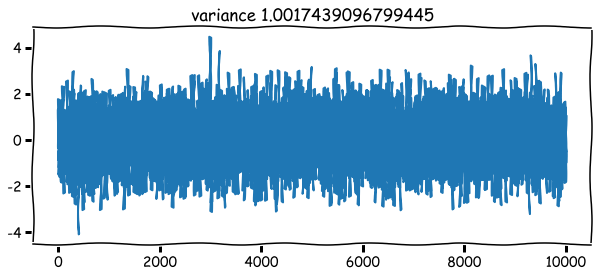

In [6]:
figsize(10,4)
data = data*sqrt(2) # to make variance unity, fft's quirks
plot(data); title('variance '+str(var(data)))

------------
<a name='chopchop'></a>
# Chop segments and make their P(f) 
### segpow will be power for the positive-f half of the symm spectrum

In [7]:
NTseg = 200 # length of segment

# Define positive half of the frequencies "freqs" 
freqs = np.array(range(NTseg//2))  

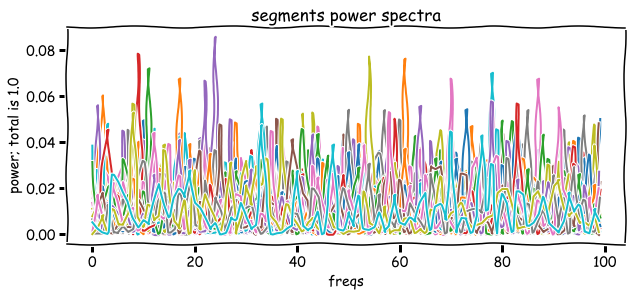

In [8]:
for iseg in range(NT//NTseg): 
    seg = data[ NTseg*iseg : NTseg*(iseg+1) ]
#    plot(seg)
    segspec = fft.fft(seg) /NTseg
    segpow2  = real(segspec.conjugate()*segspec)
    segpow = segpow2[0:NTseg//2]*2 # double P for f>0 half
    plot(freqs[0:NTseg//2],segpow[0:NTseg//2]); title('segments power spectra')
    xlabel('freqs'); ylabel('power; total is '+str(AMP**2))
# Check Parseval's theorem on total variance
#    print(sum(segpow[0:NTseg//2]))

------------

<a name='peak5'></a>
# For each segment
## find ratio of top 5 %ile segment power above analytic value
### To compare to the F test 

In [9]:
# Analytic power spectrum is total variance over NTseg/2 bins
analyticpow = AMP**2 / (NTseg/2)
analyticpow

0.01

Text(0.5,0,'frequency')

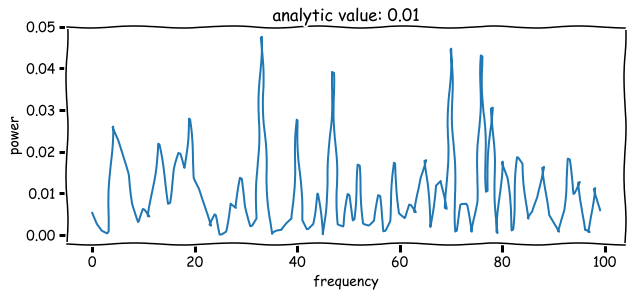

In [10]:
# example, last segment from previous loop 
plot(freqs[0:NTseg//2],segpow[0:NTseg//2] )
title('analytic value: '+str(analyticpow))
ylabel('power'); xlabel('frequency')

In [11]:
# Dividing by 20 gets you the 5th percentile 
NTseg//2//20 

5

------------

<a name='results'></a>
# Which is closer? 
#### F(2,inf) for p=0.05 is 3.07, vs. 3.92 for F(1,inf)
#### F(inf,2) for p=0.05 is 19.49, vs. 254.3 for F(inf,1)
from [here](http://www.socr.ucla.edu/Applets.dir/F_Table.html#FTable0.05)
# Answer: clearly, 2 DOFs

In [12]:
# one random sample, from the end of above loop
ratio = segpow[0:NTseg//2] / analyticpow
argsorted = argsort(ratio)
valsorted = sort(ratio)
print('95th %ile peak ratio to analytic: 3.1 or 3.9? ')
print(valsorted[-NTseg//2//20])

95th %ile peak ratio to analytic: 3.1 or 3.9? 
3.0551638298406303


In [13]:
# Loop over segments and get the mean result 
res95 = [3.1]
print('95th %ile peak ratio to analytic: 3.1 or 3.9? ')
for iseg in range(NT//NTseg): 
    seg = data[ NTseg*iseg : NTseg*(iseg+1) ]
#    plot(seg)
    segspec = fft.fft(seg) /NTseg
    segpow2  = real(segspec.conjugate()*segspec)
    segpow = segpow2[0:NTseg//2]*2 # double P for f>0 half
# Check Parseval's theorem on total variance
#    print(sum(segpow[0:NTseg//2]))
    ratio = segpow[0:NTseg//2] / analyticpow
    argsorted = argsort(ratio)
    valsorted = sort(ratio)
    print(      valsorted[-NTseg//2//20])
    res95.append(valsorted[-NTseg//2//20])
    
print('mean result '+str(mean(res95[1:])))

95th %ile peak ratio to analytic: 3.1 or 3.9? 
2.725842747919928
2.9686560287539066
3.456254000570522
3.0996837632570413
3.6482422823820246
2.88522990130584
2.876213485467991
2.472109094936296
2.98348095192508
2.618830667673116
3.6404628070100515
4.061393927629759
2.315685644737485
3.2637446995100206
3.2697302115117113
3.270553048719635
2.958357902794335
4.240208067065478
2.3127770084543275
3.1270049640851276
3.375056223422589
2.522910510510311
3.411527523415011
3.1720945922784307
3.0880384690000846
2.418047076617607
3.074207891611953
3.8661689843114218
3.5275352154458717
3.2568497209342766
2.941999198366484
2.682566401280567
3.286962974344564
2.29444609336343
3.6573159097198062
2.7883960296903507
3.4487735671561577
3.572477021751234
3.2420700970085106
2.9281467503990335
3.167429616148829
3.1100080290965653
3.148204102546125
2.7100410788349283
2.7217166139402504
2.8517944666742534
3.8810908539069646
2.634599579756361
2.9902657662834433
3.0551638298406303
mean result 3.1004073078673144


In [14]:
print('5th %ile peak ratio to analytic (inverse): 19.5 or 254? ')
res5 = [19.]
for iseg in range(NT//NTseg): 
    seg = data[ NTseg*iseg : NTseg*(iseg+1) ]
#    plot(seg)
    segspec = fft.fft(seg) /NTseg
    segpow2  = real(segspec.conjugate()*segspec)
    segpow = segpow2[0:NTseg//2]*2 # double P for f>0 half
# Check Parseval's theorem on total variance
#    print(sum(segpow[0:NTseg//2]))
    ratio = segpow[0:NTseg//2] / analyticpow
    argsorted = argsort(ratio)
    valsorted = sort(ratio)
    print(  str(1.0/valsorted[NTseg//2//20])+' at freq '+str(argsorted[NTseg//2//20]))
    res5.append(1.0/valsorted[NTseg//2//20])
    
print('mean result '+str(mean(res5[1:])))

5th %ile peak ratio to analytic (inverse): 19.5 or 254? 
18.391514499046874 at freq 62
11.60286260742974 at freq 85
7.952025059195198 at freq 75
28.565111005604415 at freq 88
30.26977324128626 at freq 77
15.359004818032687 at freq 6
27.796881905965492 at freq 68
50.352263567878225 at freq 0
15.969047648381462 at freq 4
28.005538208104504 at freq 17
15.724798131343148 at freq 88
19.567493053155207 at freq 3
10.099883344345168 at freq 18
11.443695203414537 at freq 29
16.925951866738178 at freq 32
10.199465616661024 at freq 17
21.44360133151344 at freq 41
15.208295120552021 at freq 68
27.92631200438829 at freq 4
15.951536971810787 at freq 71
9.546100090929858 at freq 24
37.439533122671264 at freq 53
14.012138978399152 at freq 33
22.58213239128901 at freq 32
19.972334249623348 at freq 94
33.89301092811261 at freq 3
11.5833419164064 at freq 58
16.19314896717479 at freq 43
21.15482021257424 at freq 33
11.61475699186187 at freq 23
12.959793955717002 at freq 29
11.268341590986392 at freq 20
50